# compare the OpenPIV Python with PIVLab


In [1]:
%reload_ext watermark
%watermark -v -m -p numpy,openpiv

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.19.0

numpy  : 1.19.4
openpiv: 0.23.3b0

Compiler    : GCC 7.3.0
OS          : Linux
Release     : 5.4.0-58-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit



In [2]:
from openpiv import windef
from openpiv import tools, scaling, validation, filters, preprocess
from openpiv.pyprocess import extended_search_area_piv, get_field_shape, get_coordinates
from openpiv import smoothn
from openpiv.preprocess import mask_coordinates

import numpy as np
import os
from time import time
import warnings


import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)


In [3]:
settings = windef.Settings()

# 'Data related settings'
# Folder with the images to process
settings.filepath_images = '../test9/'
# Folder for the outputs
settings.save_path = '.'
# Root name of the output Folder for Result Files
settings.save_folder_suffix = ''
# Format and Image Sequence
settings.frame_pattern_a = 'karman_16Hz_000_A.jpg'
settings.frame_pattern_b = 'karman_16Hz_000_B.jpg'

'Region of interest'
# (50,300,50,300) #Region of interest: (xmin,xmax,ymin,ymax) or 'full' for full image
settings.ROI = 'full'
# settings.ROI = (200,400,600,850)



settings.deformation_method = 'symmetric' # or 'second image'


settings.num_iterations = 4  # select the number of PIV passes

# add the interrogation window size for each pass. 
# For the moment, it should be a power of 2 
settings.windowsizes=(32, 16, 8, 6)
settings.overlap=(16, 8, 4, 3)

# settings.windowsizes = (128, 64, 32, 16, 8) # if longer than n iteration the rest is ignored
# The overlap of the interroagtion window for each pass.
# settings.overlap = (64, 32, 16, 8, 4) # This is 50% overlap


# Has to be a value with base two. In general window size/2 is a good choice.
# methode used for subpixel interpolation: 'gaussian','centroid','parabolic'
settings.subpixel_method = 'gaussian'

# order of the image interpolation for the window deformation
settings.interpolation_order = 1
settings.scaling_factor = 1  # scaling factor pixel/meter
settings.dt = 1  # time between to frames (in seconds)
'Signal to noise ratio options (only for the last pass)'
# It is possible to decide if the S/N should be computed (for the last pass) or not
# settings.extract_sig2noise = True  # 'True' or 'False' (only for the last pass)
# method used to calculate the signal to noise ratio 'peak2peak' or 'peak2mean'
settings.sig2noise_method = 'peak2peak'
# select the width of the masked to masked out pixels next to the main peak
settings.sig2noise_mask = 2
# If extract_sig2noise==False the values in the signal to noise ratio
# output column are set to NaN

# only effecting the first pass of the interrogation the following passes
# in the multipass will be validated

'Output options'
# Select if you want to save the plotted vectorfield: True or False
settings.save_plot = False
# Choose wether you want to see the vectorfield or not :True or False
settings.show_plot = True
settings.scale_plot = 200  # select a value to scale the quiver plot of the vectorfield
# run the script with the given settings



# 'Processing Parameters'
settings.correlation_method='linear'  # 'circular' or 'linear'
settings.normalized_correlation = True

# 'vector validation options'
# choose if you want to do validation of the first pass: True or False
settings.validation_first_pass = True


settings.filter_method = 'localmean'
# maximum iterations performed to replace the outliers
settings.max_filter_iteration = 10
settings.filter_kernel_size = 3  # kernel size for the localmean method

settings.replace_vectors = True

settings.MinMax_U_disp = (-5, 5)
settings.MinMax_V_disp = (-5, 5)

# The second filter is based on the global STD threshold
settings.std_threshold = 3  # threshold of the std validation

# The third filter is the median test (not normalized at the moment)
settings.median_threshold = 3  # threshold of the median validation
# On the last iteration, an additional validation can be done based on the S/N.
settings.median_size=1 #defines the size of the local median, it'll be 3 x 3


settings.dynamic_masking_method = 'intensity'
settings.dynamic_masking_threshold = 0.1
settings.dynamic_masking_filter_size = 21


In [4]:
vars(settings)

{'filepath_images': '../test9/',
 'save_path': '.',
 'save_folder_suffix': '',
 'frame_pattern_a': 'karman_16Hz_000_A.jpg',
 'frame_pattern_b': 'karman_16Hz_000_B.jpg',
 'ROI': 'full',
 'dynamic_masking_method': 'intensity',
 'dynamic_masking_threshold': 0.1,
 'dynamic_masking_filter_size': 21,
 'correlation_method': 'linear',
 'normalized_correlation': True,
 'windowsizes': (32, 16, 8, 6),
 'overlap': (16, 8, 4, 3),
 'num_iterations': 4,
 'subpixel_method': 'gaussian',
 'deformation_method': 'symmetric',
 'interpolation_order': 1,
 'scaling_factor': 1,
 'dt': 1,
 'sig2noise_method': 'peak2peak',
 'sig2noise_mask': 2,
 'validation_first_pass': True,
 'MinMax_U_disp': (-5, 5),
 'MinMax_V_disp': (-5, 5),
 'std_threshold': 3,
 'median_threshold': 3,
 'median_size': 1,
 'sig2noise_threshold': 1.05,
 'sig2noise_validate': True,
 'replace_vectors': True,
 'smoothn': False,
 'smoothn_p': 0.5,
 'filter_method': 'localmean',
 'max_filter_iteration': 10,
 'filter_kernel_size': 3,
 'save_plot': F

## Read and crop the images

In [5]:
file_a = settings.frame_pattern_a
file_b = settings.frame_pattern_b

# " read images into numpy arrays"
frame_a = tools.imread(os.path.join(settings.filepath_images, file_a))
frame_b = tools.imread(os.path.join(settings.filepath_images, file_b))

# " crop to ROI"
if settings.ROI == "full":
    pass
else:
    frame_a = frame_a[
        settings.ROI[0]:settings.ROI[1],
        settings.ROI[2]:settings.ROI[3]
    ]
    frame_b = frame_b[
        settings.ROI[0]:settings.ROI[1],
        settings.ROI[2]:settings.ROI[3]
    ]

## Show the images

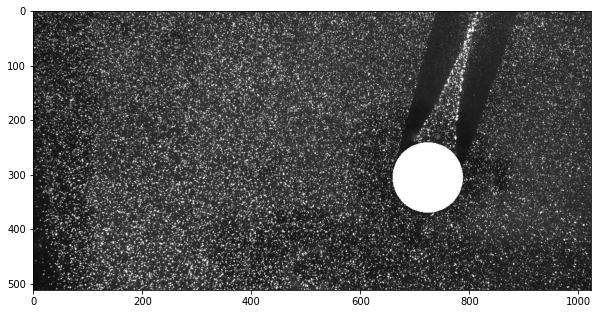

In [6]:
plt.imshow(frame_a,cmap=plt.cm.gray)

## Image masking

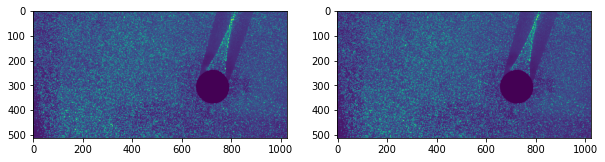

In [7]:
# 'Image preprocessing'
# 'None' for no masking, 'edges' for edges masking, 'intensity' for intensity masking
# WARNING: This part is under development so better not to use MASKS

if settings.dynamic_masking_method == "edge" or "intensity":
    frame_a, image_mask_a = preprocess.dynamic_masking(
        frame_a,
        method=settings.dynamic_masking_method,
        filter_size=settings.dynamic_masking_filter_size,
        threshold=settings.dynamic_masking_threshold,
    )
    frame_b, image_mask_b = preprocess.dynamic_masking(
        frame_b,
        method=settings.dynamic_masking_method,
        filter_size=settings.dynamic_masking_filter_size,
        threshold=settings.dynamic_masking_threshold,
    )

fig,ax = plt.subplots(1,2)
ax[0].imshow(frame_a)
ax[1].imshow(frame_b)

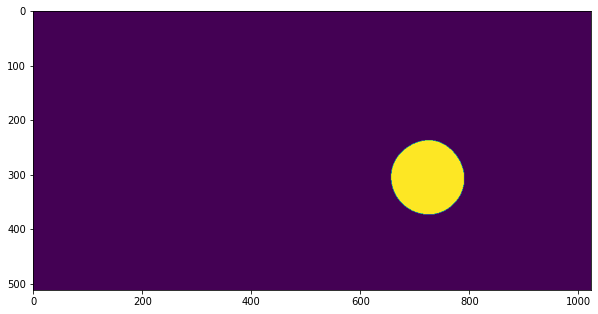

In [8]:
# let's combine the two masks if the body is slightly moving
image_mask = np.logical_and(image_mask_a, image_mask_b)
plt.imshow(image_mask)

## Exract coordinates of the mask as a list of coordinates of a polygon

In [9]:
mask_coords = mask_coordinates(image_mask)

## Run the first pass

We use typically the most robust approach: linear correlation (with zero padding)
    and normalized correlation function (0..1)

In [10]:
# In order to convert the image mask to the data mask in x,y 
# coordinates, we have to either run first pass or 
# use get_coordinates
# Since we do not know how to use the image_mask in the 
# first pass with the vectorized correlations, i.e. how to 
# save some computational time by skipping the interrogation
# windows within the image mask, we just run the first pass


# "first pass"
x, y, u, v, sig2noise_ratio = windef.first_pass(
    frame_a,
    frame_b,
    settings
)

# store for the comparison of the following steps
u0 = u.copy()
v0 = v.copy()

def status_message(u):
    print(f"{np.isnan(u).sum()/u.size*100:.2f}% invalid vectors out of {u.size} vectors")
    
status_message(u)

1.43% invalid vectors out of 1953 vectors


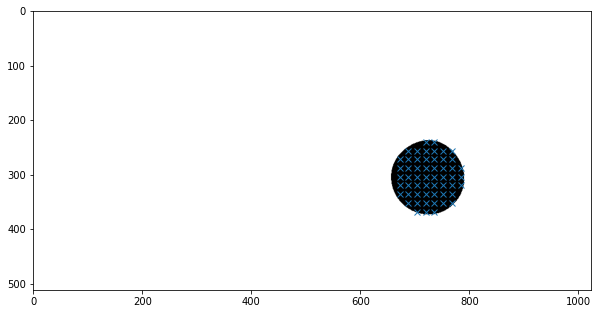

In [11]:
# Now we can convert the image mask to the data mask in x,y coordinates

from skimage.measure import points_in_poly

# mark those points on the grid of PIV inside the mask
xymask = points_in_poly(np.c_[y.flatten(),x.flatten()],mask_coords)

plt.imshow(~image_mask,cmap=plt.cm.gray)
plt.plot(x.flat[xymask],y.flat[xymask],'x')

In [12]:
# mask the velocity maps for the future use in validation
tmp = np.zeros_like(x,dtype=bool)
tmp.flat[xymask] = True

u = np.ma.masked_array(u, mask = tmp)
v = np.ma.masked_array(v, mask = tmp)

In [13]:
# we need to remove those values for the display
def quick_quiver():
    """ u,v expected to have a mask """
    plt.quiver(x,y,u,-v,sig2noise_ratio, scale=50,color='b')
    plt.gca().invert_yaxis()
    plt.gca().set_aspect(1)
    plt.plot(x.flat[xymask],y.flat[xymask],'rx')
    plt.colorbar(orientation='horizontal')

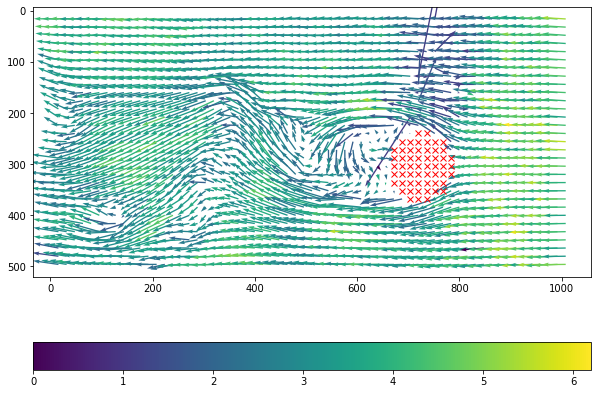

In [14]:
quick_quiver()

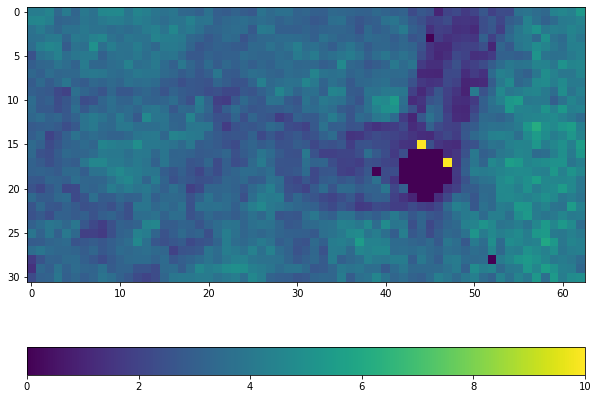

In [15]:
# see the distribution of the signal to noise ratio
tmp = sig2noise_ratio.copy()
tmp[tmp>10] = 10  # there are some extra high values 1e7 ...
plt.imshow(tmp)
plt.colorbar(orientation='horizontal')

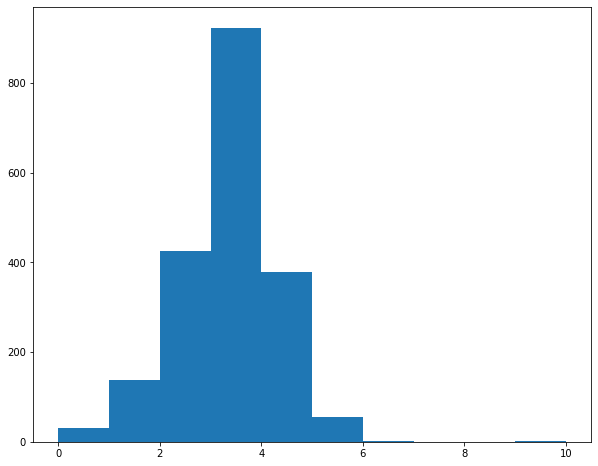

In [16]:
plt.hist(tmp.flatten());

In [17]:
# let's consider 5% of signoise ratio problems. 
sig2noise_threshold = np.percentile(sig2noise_ratio,(2.5))
print(f"S2N threshold is estimated as {sig2noise_threshold:.3f}")

settings.sig2noise_threshold = 1.2

S2N threshold is estimated as 1.247


In [18]:
u, v, mask_s2n = validation.sig2noise_val(
            u, v, sig2noise_ratio,
            threshold=settings.sig2noise_threshold
)

status_message(u)

2.30% invalid vectors out of 1953 vectors


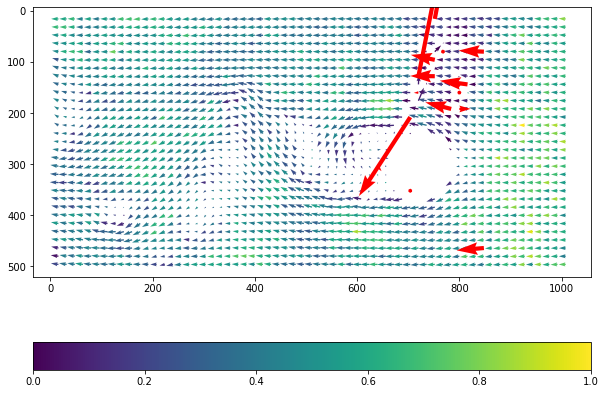

In [19]:
plt.figure()
plt.quiver(x,y,u,-v,sig2noise_ratio)
plt.quiver(x[mask_s2n],y[mask_s2n],u0[mask_s2n],-v0[mask_s2n],color='r')
plt.gca().invert_yaxis()
plt.gca().set_aspect(1.)
plt.colorbar(orientation='horizontal')

In [20]:
# False everywhere, all passes
outliers_mask = np.zeros_like(x, dtype=bool)

(array([1.000e+00, 1.000e+00, 0.000e+00, 3.500e+01, 6.000e+01, 2.300e+02,
        1.154e+03, 2.910e+02, 1.250e+02, 1.100e+01]),
 array([-3.95075851, -3.3404321 , -2.7301057 , -2.11977929, -1.50945289,
        -0.89912648, -0.28880008,  0.32152633,  0.93185273,  1.54217914,
         2.15250554]),
 <BarContainer object of 10 artists>)

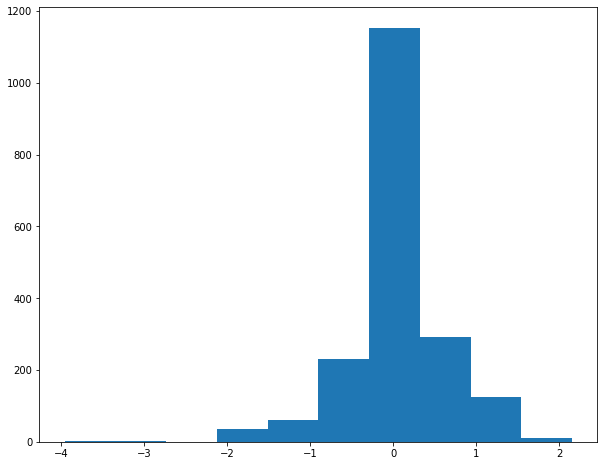

In [21]:
plt.hist(v.flatten())

In [22]:
# 'Validation Parameters'
# The validation is done at each iteration based on three filters.
# The first filter is based on the min/max ranges. Observe that these values are defined in
# terms of minimum and maximum displacement in pixel/frames.

u, v, mask_g = validation.global_val(
    u, v, settings.MinMax_U_disp, settings.MinMax_V_disp
)
status_message(u)

2.30% invalid vectors out of 1953 vectors


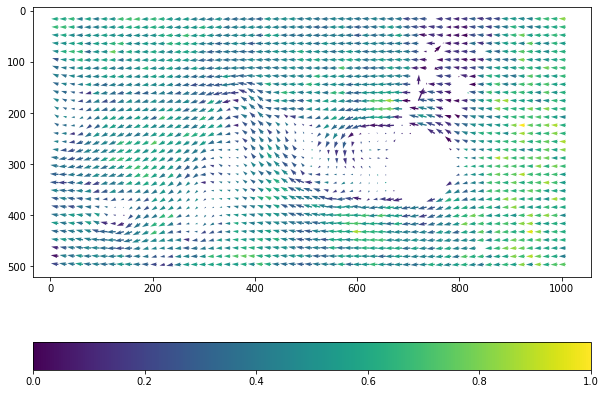

In [23]:
plt.figure()
plt.quiver(x,y,u,-v,sig2noise_ratio)
plt.quiver(x[mask_g],y[mask_g],u0[mask_g],-v0[mask_g],color='r')
plt.gca().invert_yaxis()
plt.gca().set_aspect(1.)
plt.colorbar(orientation='horizontal')

In [24]:
## also global std should take masked array

In [25]:
# The second filter is based on the global STD threshold
settings.std_threshold = 5  # threshold of the std validation

u, v, mask_s = validation.global_std(
    u, v, std_threshold=settings.std_threshold
)


status_message(u)

3.38% invalid vectors out of 1953 vectors


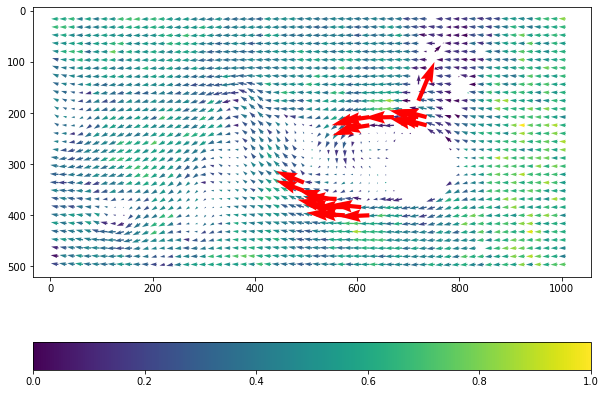

In [26]:
plt.figure()
plt.quiver(x,y,u,-v,sig2noise_ratio)
plt.quiver(x[mask_s],y[mask_s],u0[mask_s],-v0[mask_s],color='r')
plt.gca().invert_yaxis()
plt.gca().set_aspect(1.)
plt.colorbar(orientation='horizontal')

In [27]:
## validation.local_median_val should also take masked array

In [28]:
# The third filter is the median test (not normalized at the moment)
settings.median_threshold = 3  # threshold of the median validation
# On the last iteration, an additional validation can be done based on the S/N.
settings.median_size=1 #defines the size of the local median

u, v, mask_m = validation.local_median_val(
    u,
    v,
    u_threshold=settings.median_threshold,
    v_threshold=settings.median_threshold,
    size=settings.median_size,
)


status_message(u)

3.53% invalid vectors out of 1953 vectors


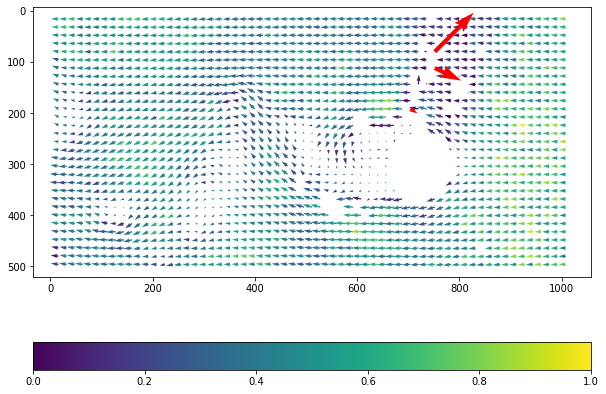

In [29]:
plt.figure()
plt.quiver(x,y,u,-v,sig2noise_ratio)
plt.quiver(x[mask_m],y[mask_m],u0[mask_m],-v0[mask_m],color='r')
plt.gca().invert_yaxis()
plt.gca().set_aspect(1.)
plt.colorbar(orientation='horizontal')

In [30]:
# Combining masks
outliers_mask = mask_g + mask_m + mask_s + mask_s2n

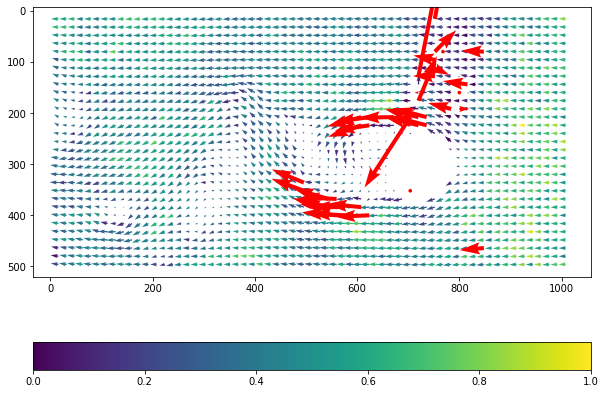

In [31]:
plt.figure()
plt.quiver(x,y,u,-v,sig2noise_ratio)
plt.quiver(x[outliers_mask],y[outliers_mask],
           u0[outliers_mask],-v0[outliers_mask],color='r')
plt.gca().invert_yaxis()
plt.gca().set_aspect(1.)
plt.colorbar(orientation='horizontal')

In [32]:
status_message(u)

3.53% invalid vectors out of 1953 vectors


In [33]:
# "filter to replace the values that where marked by the validation"
# if settings.num_iterations > 1:


u, v = filters.replace_outliers(
    u,
    v,
    method=settings.filter_method,
    max_iter=settings.max_filter_iteration,
    kernel_size=settings.filter_kernel_size,
)


In [34]:
# mask the velocity maps
tmp = np.zeros_like(x,dtype=bool)
tmp.flat[xymask] = 1

u = np.ma.masked_array(u, mask = tmp)
v = np.ma.masked_array(v, mask = tmp)

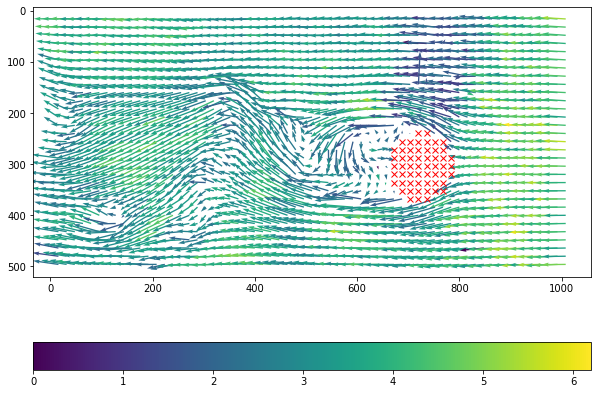

In [35]:
quick_quiver()

In [36]:
# Smoothing after the first pass
settings.smoothn=True #Enables smoothing of the displacemenet field
settings.smoothn_p=0.5 # This is a smoothing parameter

u, dummy_u1, dummy_u2, dummy_u3 = smoothn.smoothn(
    u, s=settings.smoothn_p
)
v, dummy_v1, dummy_v2, dummy_v3 = smoothn.smoothn(
    v, s=settings.smoothn_p
)

# mask the velocity maps
tmp = np.zeros_like(x,dtype=bool)
tmp.flat[xymask] = 1

u = np.ma.masked_array(u, mask = tmp)
v = np.ma.masked_array(v, mask = tmp)

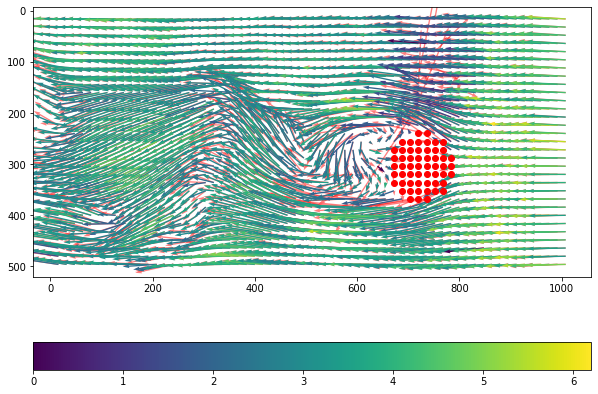

In [37]:
# x, y, u, v = tools.transform_coordinates(x, y, u, v)

plt.figure()
plt.quiver(x,y,u0,-v0,color='r',scale=30,alpha=0.5)
plt.quiver(x,y,u,-v,sig2noise_ratio,scale=30)
plt.plot(x.flat[xymask],y.flat[xymask],'ro')
plt.gca().invert_yaxis()
plt.colorbar(orientation='horizontal')
plt.gca().set_aspect(1.)

## Multi-pass loop with window deformation, validation and smoothing

**Note**: no smoothing on the last step

In [38]:
# TODO: study the sig2noise validation in multipass

settings.sig2noise_validate = False

for i in range(1, settings.num_iterations): ## all other passes
    x, y, u, v, sig2noise_ratio, mask = windef.multipass_img_deform(
        frame_a,
        frame_b,
        i,
        x,
        y,
        u,
        v,
        settings,
        mask_coords=mask_coords,
    )

global filter invalidated 7 vectors
median filter invalidated 16 vectors
global filter invalidated 29 vectors
median filter invalidated 25 vectors
global filter invalidated 25 vectors
median filter invalidated 15 vectors


## Save the outcome

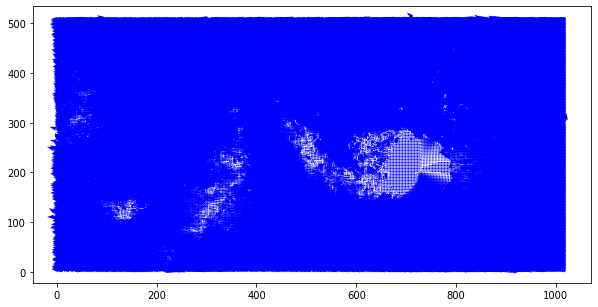

<Figure size 720x576 with 0 Axes>

Image Pair 1


In [39]:
save_path = '.'
counter = 0

# "pixel/frame->pixel/sec"
u = u / settings.dt
v = v / settings.dt

# "scales the results pixel-> meter"
x, y, u, v = scaling.uniform(x, y, u, v,
                             scaling_factor=settings.scaling_factor)

x, y, u, v = tools.transform_coordinates(x, y, u, v)

# "save to a file"
tools.save(
    x,
    y,
    u,
    v,
    mask,
    os.path.join(save_path, "field_A%03d.txt" % counter),
    delimiter="\t",
)

# "some other stuff that one might want to use"
settings.show_plot = True
settings.save_plot = True

if settings.show_plot is True or settings.save_plot is True:
    plt.close("all")
    plt.ioff()
    filename = os.path.join(save_path, "Image_A%03d.png" % counter)
    tools.display_vector_field(
        os.path.join(save_path, "field_A%03d.txt" % counter),
        scale=settings.scale_plot,
    )
    if settings.save_plot is True:
        plt.savefig(filename)
    if settings.show_plot is True:
        plt.show()

print("Image Pair " + str(counter+1))

['field_A000.txt']


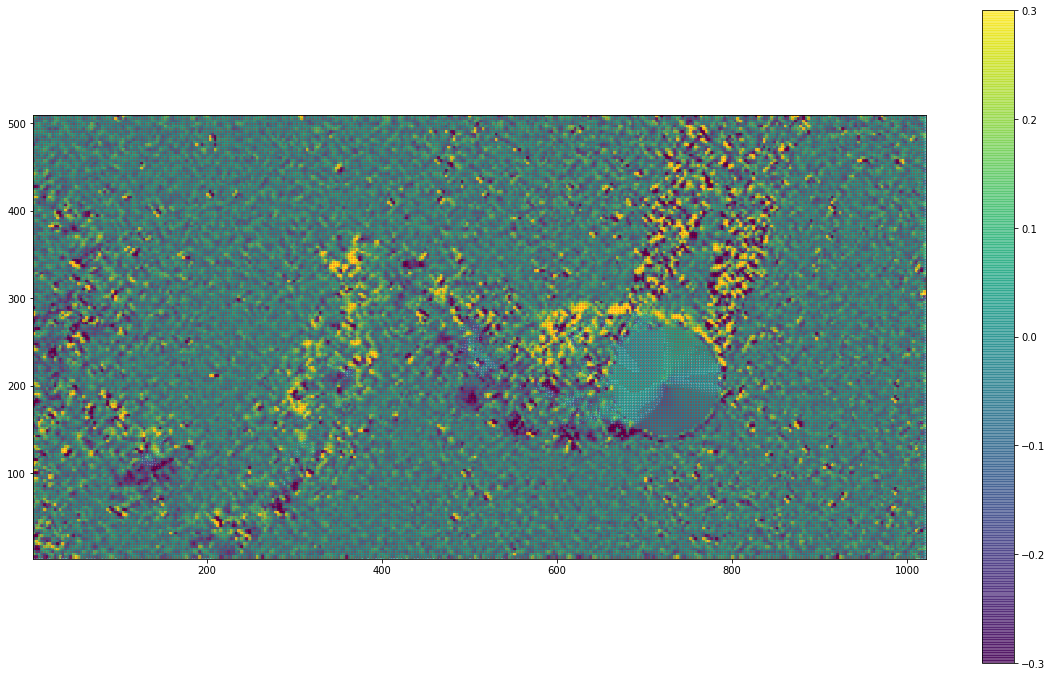

In [40]:
import glob
import xarray as xr
from pivpy import io, pivpy

file_list = sorted(glob.glob("field_A%03d.txt" % counter))
print(file_list)

data = []
frame = 0
for f in file_list:
    data.append(io.load_txt(f,frame=frame))
    frame += 1
    
data = xr.concat(data,dim='t')
data.attrs['units']= ['pix','pix','pix/dt','pix/dt']
data.piv.vorticity();

import matplotlib.pyplot as plt

def plot_data(data):
    fig, ax = plt.subplots(1,1,figsize=(20,12))
    # for ax in axs:
    ax.quiver(data.x.data, data.y.data, data.u.isel(t=0).data.T, data.v.isel(t=0).data.T, color='r', scale=120)
    s = ax.pcolor(data.x,data.y,data.w.T.isel(t=0), shading='interp', vmin=-.3, vmax=.3,alpha=0.7)
    ax.set_aspect(1)
    fig.colorbar(s, ax=ax,)
    plt.show()
    
    
plot_data(data)